### Preview dataset and some examples with images

Dataset Information:
Total number of images: 2527

Number of images per category:
category
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64

First 5 rows of the dataset:
                                          image_path category
0  data/garbage classification/Garbage classifica...    paper
1  data/garbage classification/Garbage classifica...    paper
2  data/garbage classification/Garbage classifica...    paper
3  data/garbage classification/Garbage classifica...    paper
4  data/garbage classification/Garbage classifica...    paper


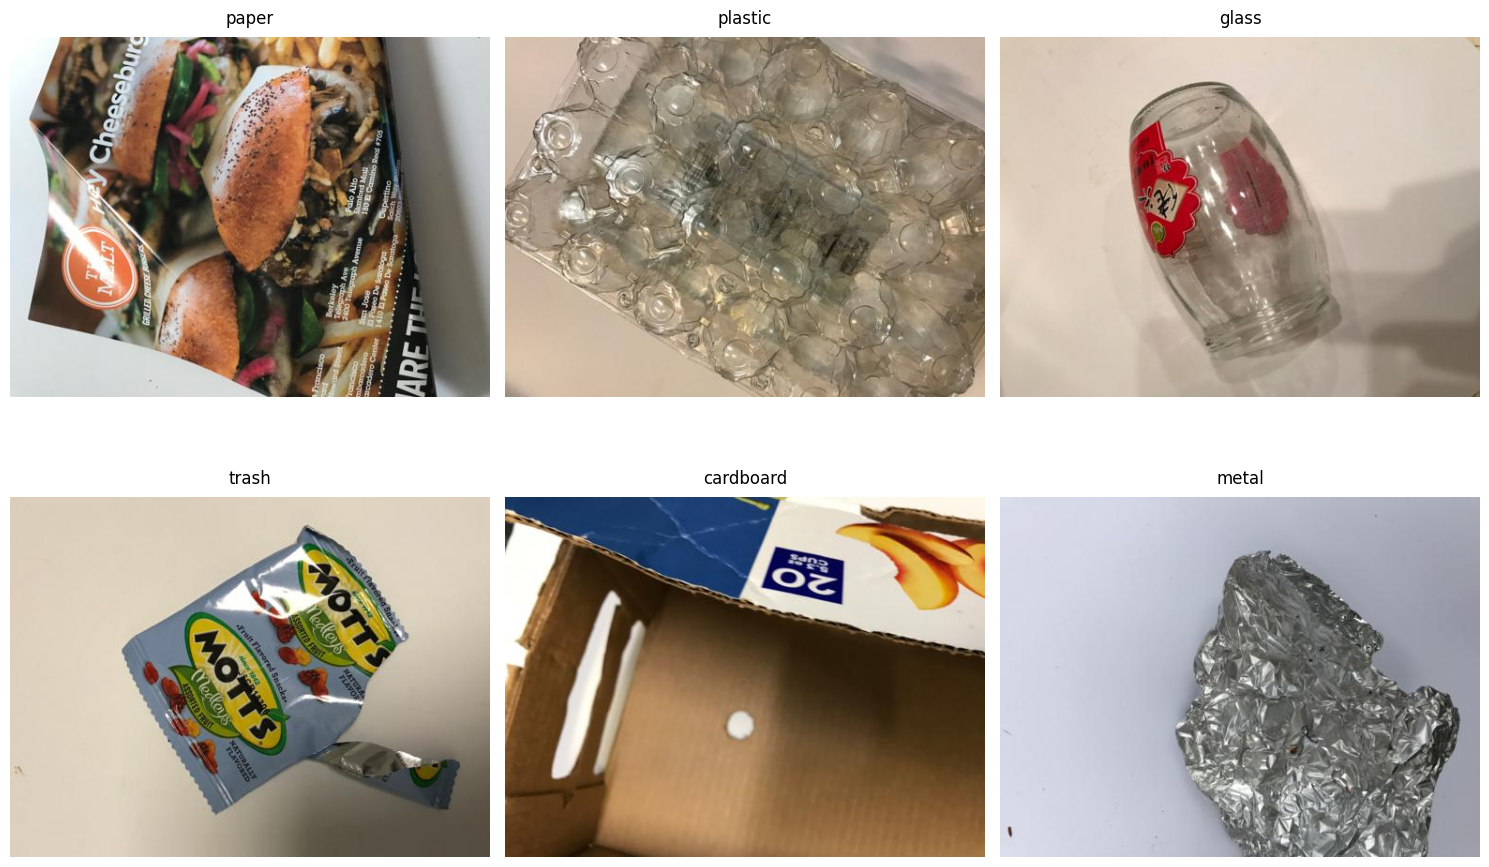


Image Statistics:

Image dimensions statistics:
        width  height
count  2527.0  2527.0
mean    512.0   384.0
std       0.0     0.0
min     512.0   384.0
25%     512.0   384.0
50%     512.0   384.0
75%     512.0   384.0
max     512.0   384.0


In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Set up matplotlib for better visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]

# Define the base path to the dataset
base_path = Path('data/garbage classification/Garbage classification')

# Create lists to store the data
image_paths = []
categories = []

# Walk through the directory and collect all image paths and their categories
for category in os.listdir(base_path):
    category_path = base_path / category
    if os.path.isdir(category_path):
        for image_file in os.listdir(category_path):
            if image_file.endswith('.jpg'):
                image_paths.append(str(category_path / image_file))
                categories.append(category)

# Create the DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'category': categories
})

# Display basic information about the dataset
print("Dataset Information:")
print(f"Total number of images: {len(df)}")
print("\nNumber of images per category:")
print(df['category'].value_counts())

# Display the first few rows of the DataFrame
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Create a figure with subplots for each category
plt.figure(figsize=(15, 10))

# Get one example from each category
for idx, category in enumerate(df['category'].unique()):
    # Get the first image path for this category
    image_path = df[df['category'] == category]['image_path'].iloc[0]
    
    # Create subplot
    plt.subplot(2, 3, idx + 1)
    
    # Read and display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(category, fontsize=12, pad=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Display some statistics about image sizes
print("\nImage Statistics:")
image_sizes = []
for path in df['image_path']:
    img = Image.open(path)
    image_sizes.append(img.size)

sizes_df = pd.DataFrame(image_sizes, columns=['width', 'height'])
print("\nImage dimensions statistics:")
print(sizes_df.describe())